# COVID-19 Radiography

Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145 (Links to an external site.).

In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
# Download and unzip data
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/COVID-19_Radiography_Database.zip
1.22GB [00:12, 94.7MB/s]
Archive:  COVID-19_Radiography_Database.zip
replace COVID-19 Radiography Database/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1005).png  
  inflating: COVID-19 Radiog

#### Load and preprocess images

In [3]:
# Load libraries 

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [4]:
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [5]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL','Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (410).png', 'COVID-19 Radiography Database/COVID/COVID (213).png', 'COVID-19 Radiography Database/COVID/COVID (597).png', 'COVID-19 Radiography Database/COVID/COVID (119).png', 'COVID-19 Radiography Database/COVID/COVID (634).png', 'COVID-19 Radiography Database/COVID/COVID (1187).png', 'COVID-19 Radiography Database/COVID/COVID (610).png', 'COVID-19 Radiography Database/COVID/COVID (167).png', 'COVID-19 Radiography Database/COVID/COVID (510).png', 'COVID-19 Radiography Database/COVID/COVID (655).png', 'COVID-19 Radiography Database/COVID/COVID (700).png', 'COVID-19 Radiography Database/COVID/COVID (1092).png', 'COVID-19 Radiography Database/COVID/COVID (250).png', 'COVID-19 Radiography Database/COVID/COVID (15).png', 'COVID-19 Radiography Database/COVID/COVID (1060).png', 'COVID-19 Radiography Database/COVID/COVID (1105).png', 'COVID-19 Radiography Database/COVID/COVID (64).png', 'COVID

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (1001).png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
X.shape

(3886, 192, 192, 3)

In [9]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

3886
(192, 192, 3)
0.0
1.0


(3886, 192, 192, 3)

In [10]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [1200, 1341, 1345]


In [11]:
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
len(y_labels) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


In [12]:
X[0].shape

(192, 192, 3)

#### Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to.).

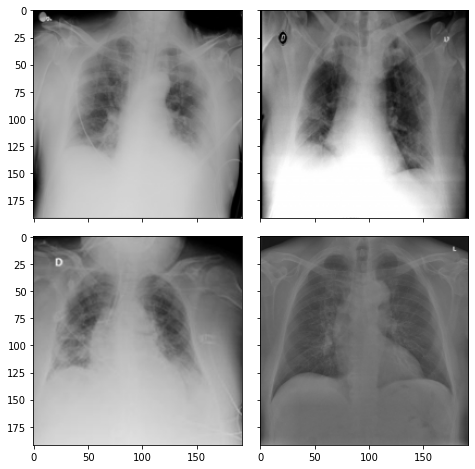

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png')
im2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (10).png')
im3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (100).png')
im4 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1001).png')

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

# Visualize COVID positivity
for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

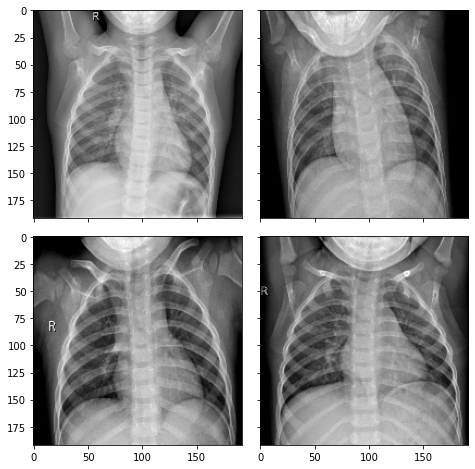

In [14]:
# Visualize COVID negativity
fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )


im1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
im2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (10).png')
im3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (100).png')
im4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1001).png')

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

#### Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful. Who could benefit from a model like this? Explain.


This is a set of chest X-ray images for COVID-19 positive cases, Normal and Viral Pneumonia images data.  there are 1200 COVID-19 positive images, 1341 normal images and 1345 viral pneuomonia images. 
Building such predictive model using this data might be useful to detect whether the person has COVID or not. For example, it could be useful for someone in the emergency room, to take image of the person's X-ray chest and get result immediately. If the model is good, it can increase accuracy of prediction of whether the person has COVID or not. 


#### Run at least three prediction models to try to predict x-ray images well. Use transfer learning for at least one of these models

In [15]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3108, 192, 192, 3), (778, 192, 192, 3), (3108, 3), (778, 3))

##### Model 1: Densely Connected Feed Forward NN for Baseline.

In [17]:
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model1 = Sequential()
      model1.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model1.add(Dense(64, activation='relu'))
      model1.add(Flatten())
      model1.add(Dense(3, activation='softmax')) 
                                                  
      # Compile model
      model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model1.fit(X_train, y_train, 
                    epochs = 5, verbose=1, validation_data=(X_test,y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.6881 - acc: 0.6840 - val_loss: 0.5489 - val_acc: 0.8046
Epoch 2/5
3108/3108 [==============================] - 8s 3ms/sample - loss: 0.4364 - acc: 0.8481 - val_loss: 0.8266 - val_acc: 0.6260
Epoch 3/5
3108/3108 [==============================] - 8s 3ms/sample - loss: 0.3830 - acc: 0.8504 - val_loss: 0.3288 - val_acc: 0.8920
Epoch 4/5
3108/3108 [==============================] - 8s 3ms/sample - loss: 0.3336 - acc: 0.8768 - val_loss: 0.3141 - val_acc: 0.8779
Epoch 5/5
3108/3108 [==============================] - 8s 3ms/sample - loss: 0.3053 - acc: 0.8893 - val_loss: 0.2761 - val_acc: 0.9049


{'name': 'SGD', 'learning_rate': 0.001, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
{'name': 'sequential', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': No

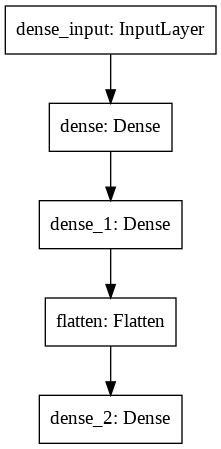

In [18]:
import tensorflow.keras.backend as K

print(K.eval(model1.optimizer.get_config()))

print(model1.get_config())

print(len(model1.history.epoch))
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model.png')

##### Model 2: Convolutional Neural Network

In [19]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 2 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
  from tensorflow.keras.optimizers import Adam
  
  # stop if no improvement in val acc after 3 epochs
  early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
  
  # reduce learning rate if val plateaus
  red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  # optimizer instance for use with reduce learning rate callback
  opt = Adam(learning_rate=0.001)
  

  model2.compile( 
    optimizer=opt,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  # Fitting the CNN to the Training set
  model2.fit(X_train, y_train, epochs = 5, verbose=1,validation_data=(X_test,y_test), callbacks=[early, red_lr])

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 11s 4ms/sample - loss: 0.5371 - acc: 0.7654 - val_loss: 0.3617 - val_acc: 0.8368
Epoch 2/5
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.2674 - acc: 0.9073 - val_loss: 0.1986 - val_acc: 0.9306
Epoch 3/5
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1857 - acc: 0.9366 - val_loss: 0.1975 - val_acc: 0.9383
Epoch 4/5
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1435 - acc: 0.9476 - val_loss: 0.1999 - val_acc: 0.9383
Epoch 5/5
3108/3108 [==============================] - 5s 2ms/sample - loss: 0.1064 - acc: 0.9620 - val_loss: 0.1388 - val_acc: 0.9589


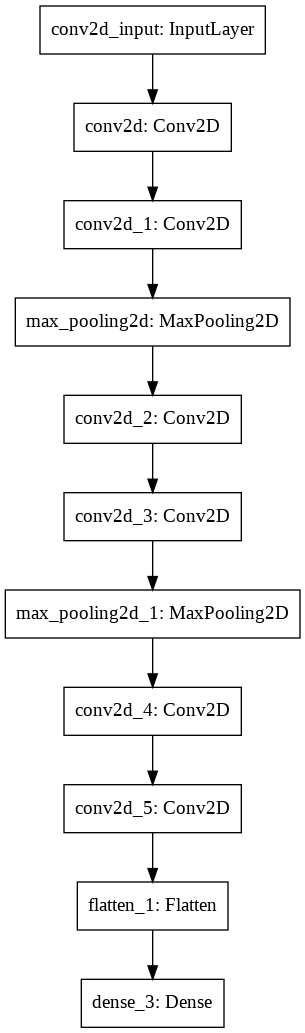

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model.png')

##### Model 3: Transfer Learning Model

In [21]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(192,192,3), include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [22]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model.trainable = False

from keras.regularizers import l2
model3 = Sequential([
  base_model,
   Conv2D(512,(1,1),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   GlobalAveragePooling2D(),
   Dense(3 ,activation="softmax")
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 512)         262656    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 1024)        4719616   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 1024)        9438208   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 29,138,243
Trainable params: 14,423,555
Non-trainable params: 14,714,688
_________________________________

Using TensorFlow backend.


In [23]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs
  early = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

  model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model3.fit(X_train, y_train,batch_size=1,
             epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[early, mc, red_lr])

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3106/3108 [============================>.] - ETA: 0s - loss: 0.5669 - acc: 0.7534
Epoch 00001: val_acc improved from -inf to 0.90360, saving model to best_model.h5
3108/3108 [==============================] - 70s 23ms/sample - loss: 0.5671 - acc: 0.7532 - val_loss: 0.2961 - val_acc: 0.9036
Epoch 2/5
3106/3108 [============================>.] - ETA: 0s - loss: 0.2733 - acc: 0.9028
Epoch 00002: val_acc improved from 0.90360 to 0.92931, saving model to best_model.h5
3108/3108 [==============================] - 70s 22ms/sample - loss: 0.2731 - acc: 0.9028 - val_loss: 0.2058 - val_acc: 0.9293
Epoch 3/5
3105/3108 [============================>.] - ETA: 0s - loss: 0.2090 - acc: 0.9262
Epoch 00003: val_acc improved from 0.92931 to 0.93830, saving model to best_model.h5
3108/3108 [==============================] - 70s 23ms/sample - loss: 0.2090 - acc: 0.9260 - val_loss: 0.1869 - val_acc: 0.9383
Epoch 4/5
3106/3108 [=======================

#### Discuss which models performed better and point out relevant hyper-parameter values for successful models.

In [24]:
# Now we can extract some evaluative metrics to use for model submission
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

# using predict_classes() for multi-class data to return predicted class index.
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata


In [25]:
### evaluate Deep Feed Forward model 1

prediction_index=predict_classes(model1.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test.idxmax(axis=1) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics(y_test_labels, predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.904884,0.90638,0.907893,0.906655,0,0,0,0


In [26]:
### evaluate CNN model 2

# predict COVID/NORMAL labels for CNN model 2

prediction_index=predict_classes(model2.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test.idxmax(axis=1) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics(y_test_labels, predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.958869,0.959,0.959363,0.9587,0,0,0,0


In [27]:
### evaluate transfer learning model 3

prediction_index=predict_classes(model3.predict(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))

# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test.idxmax(axis=1) #returns a pandas series of predicted labels

# get metrics
model_eval_metrics(y_test_labels, predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.956298,0.957428,0.957594,0.957419,0,0,0,0


#### Submit your best model to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [32]:
#install aimodelshare library
! pip install aimodelshare --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/


In [33]:
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx
from aimodelshare.aws import set_credentials
import os

In [35]:

import aimodelshare as ai
def preprocessor(data):
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

# transform sklearn model to ONNX
### Pass in model = model1, model2, or model3 depending which one is best

onnx_model_keras = model_to_onnx(model1, framework='keras', 
                                transfer_learning=True,
                                deep_learning=True,
                                task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

# Set credentials to submit new model/preprocessor
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

The ONNX operator number change on the optimization: 14 -> 10
The maximum opset needed by this model is only 11.


AI Model Share login credentials set successfully.
AWS credentials set successfully.


'Your model has been submitted as model version 31'

#### Import the best model from the leader board (whatever the best model is after your final submission) Note: Use the aimodelshare instantiate_model() function

In [36]:
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
data.fillna(0,inplace=True)
ai.stylize_leaderboard(data,category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,version
0,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
2,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
3,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
4,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18
5,97.04%,97.08%,97.17%,97.13%,keras,True,True,Model,34,20232011,str,Adam,"{'name': 'model_15', 'layers':...",dv2438,28
6,96.92%,96.99%,96.98%,97.01%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential_1', 'laye...",xcin,23
7,96.14%,96.20%,96.15%,96.28%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential', 'layers...",xcin,29
8,95.89%,95.93%,96.01%,95.87%,keras,True,True,Sequential,16,41083,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,2
9,95.63%,95.74%,95.76%,95.74%,keras,True,True,Sequential,4,7082307,str,SGD,"{'name': 'sequential', 'layers...",xcin,31


In [78]:
from aimodelshare.aimsonnx  import instantiate_model



In [79]:
# instantiate or create top model/ get help on how to use ai.instantiate_model
from keras.initializers import glorot_uniform
from keras.utils import CustomObjectScope
from aimodelshare.aimsonnx  import instantiate_model
with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
  top_model = instantiate_model("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m", token, awscreds, version=23)

In [ ]:
help(ai.aimsonnx)

#### Visualize the model's structure using tf.kera's model.summary()

In [80]:
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 192, 192, 64)      256       
_________________________________________________________________
dense_4 (Dense)              (None, 192, 192, 64)      4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2359296)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 7077891   
Total params: 7,082,307
Trainable params: 7,082,307
Non-trainable params: 0
_________________________________________________________________


#### Explain how the model's structure is different from your best model.

Compare summary of your model with top model


The difference between the top model (Version 7) and my model is that, the accuracy and f1 score are much higher with 98.59% accuracy and f1_scroe of 98,65%

It uses transfer learning method and uses functional API. The maximum depth of the model is 22, and contains 33593155 number of parameters. It uses Adam optimizer. 


Compared with my model, it has an accuracy of 97%, and uses Sequential API. It uses SGD optimizer, has 4 layers and 7082307 parameters. 

#### Explain how the model's optimization approach is different from your best model

#### Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [83]:

top_model.compile(optimizer='adam', loss='mean_squared_error')
top_model.fit(X_train, y_train,batch_size=1,
              epochs = 5, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Train on 3108 samples, validate on 778 samples


AttributeError: ignored

In [ ]:
model3.fit